# 文本相似度初探
我们开始讨论测量文本相似度问题，我们的问题是比较一般化的问题:给定训练文本(比如若干句子对），测试文本（比如若干句子对）以及对应的标签（比如句子对的相似程度，数值表示），我们需要利用一些方法在训练数据上进行无监督的训练或不训练
，然后在测试文本上进行测试，以确定什么是好的测量文本相似性的方法。
给定输入文本，为了输出相似度，我们将文本相似测量方法分为两核心阶段：文本表示阶段和相似性计算阶段，并分别总结一些基础方法，并进行组合，最后利用典型数据:http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark 和
https://github.com/nlptown/nlp-notebooks/blob/master/Simple%20Sentence%20Similarity.ipynb 中的SICK和STS数据来进行实验。
## 文本表示
文本有若干种表示方法，如原始表示，token集合表示，词向量集合表示，句子向量表示等。原始表示就是指文本原始的字符串，token集合是指文本经过分词和其他处理后形成的token集合，词向量集合表示指文本经过词向量模型转后得到的词向量的集合，句子向量表示等指文本经过transformers，主题模型等转换后得到的句子向量表示,我们列出来：

|表示方法类别   | 模型       |
|---------    | ---       |
|原始表示      |           |
|token集合表示 |           |
|词向量集合表示 |word2vec   |
|句子向量表示   |transformer|

## 相似度计算
我们有许多的相似度计算方法，在https://github.com/life4/textdistance 的划分基础上，我们稍加修改，相似度计算方法可分为基于字符串的，基于句子向量的
，基于压缩的，基于编辑的，基于token的和基于词向量的方法。我们不去一一解释这些方法，因为这些基础方法可以很方便的在textdistance包和其他地方搜索到。
我们列出来:

|相似度计算类别   | 方法列表       |
|-----------    |-------       |
|基于压缩的      | ArithNCD,LZMANCD,BZ2NCD,RLENCD,BWTRLENCD,ZLIBNCD,SqrtNCD,EntropyNCD          |
|基于编辑的      |     Hamming,MLIPNS,Levenshtein, DamerauLevenshtein,Jaro, JaroWinkler, StrCmp95,NeedlemanWunsch, Gotoh, SmithWaterman      |
|基于词向量的    |WmdDistance   |
|基于token的| Jaccard, Sorensen, Tversky,Overlap, Cosine, Tanimoto, MongeElkan, Bag|
|基于句子向量的   |Chebyshev, Minkowski, Euclidean|

## 预处理和后处理方法
除了文本表示和相似度计算方法我们还需要预处理和后处理阶段才能形成完整的相似度计算流程，对于预处理阶段我们仅使用两种：不处理或分词；对于后处理阶段，我们对词向量模型和transformer模型的结果做一些处理以方便能使用不同的相似度计算方法，如：基于词向量的方法或基于句子向量的方法。

 | 预处理方法       |
|-------       |
|tokenlize(分词)|
|move_stopword|

|模型      | 后处理方法       |
|-------  |-------       |
|word2vec | Avg(平均化所有词向量），Maxpool(对于多个词向量的每个维度取最大的)|
|transformer|Avg(平均化所有输出向量），Maxpool(对于多个输出向量的每个维度取最大的)，SelectOne(取第一个输出向量：即[cls]字符代表的向量，其他的不用。)|


好了，有了预处理，文本表示，后处理，相似度计算方法，我们就可以依次连接它们，进行不同的组合，形成不同的文本相似度计算的pipeline，即：完整的文本相似度计算流程，随后依此进行试验，来看看不同的pipeline的结果。我们不在此列出具体的pipline了，我们会在后续的实验中展示出来。

In [1]:
import itertools
import pandas as pd
import numpy as np
import scipy
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gensim.models as gsm
import yaml
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import nltk
import textdistance_master.textdistance as td
from transformers import AutoModel,AutoConfig,AutoTokenizer,AutoFeatureExtractor,AutoModelForTokenClassification,AutoModelWithLMHead
import gensim
import mlflow
from mlflow import log_metric, log_param, log_artifacts
from random import random, randint
from  dataloader.dataloader import DataLoader
from models.model import Word2Vec,GensimModel
from textdistance_master.textdistance.algorithms.base import Base as _Base, BaseSimilarity as _BaseSimilarity
import numpy as np
from gensim.corpora import dictionary
from functools import reduce
from pyemd import emd
from gensim import corpora, models, similarities
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
import yaml

d:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
d:\ProgramData\Anaconda3\lib\site-packages\sk

In [2]:
#定义Wmd距离
class WmdDistance(_BaseSimilarity):
    def __call__(self, *sequences):
        assert len(sequences)==2
        document1,document2 = sequences
        docvec1,document1 = document1[:len(document1)//2],document1[len(document1)//2:]
        docvec2,document2 = document2[:len(document2)//2],document2[len(document2)//2:]
        docdict1 = {word:vec for word,vec  in zip(document1,docvec1 )}
        docdict2 = {word:vec for word,vec  in zip(document2,docvec2)}
        docdict1.update(docdict2)
        docdict = {word:0 for word in document1+document2}
        def f(x,y):
            x[list(y.keys())[0]] = x.get(list(y.keys())[0],0)+1
            return x
        d1 =reduce(f,[docdict.copy()]+[{key:1} for key in document1])
        d2 =reduce(f,[docdict.copy()]+[{key:1} for key in document2])
        # Compute WMD.
        distance_matrix = np.array([[np.sqrt(np.sum((docdict1[list(d1.keys())[i]]-docdict1[list(d2.keys())[j]])**2))for i in range(len(d1))] for j in range(len(d2))] ,dtype='float64')
        return emd(np.array([value/len(d1) for value in list(d1.values())]), np.array([value/len(d2) for value in list(d2.values())]), distance_matrix)

In [3]:
#封装gensim包方便调用
class BaseModel:
    def __init__(self,**config):
        self.config = config
    def load(self):
        pass
    def train(self):
        pass
    def __call__(self, sentence_tokens):
        pass
class Word2Vec(BaseModel):
    def __init__(self,**config):
        super().__init__(**config)
        self.word2vec_path = config['vectors_path']#"e:/data/word2vec/GoogleNews-vectors-negative300.bin"
        self.word2vec = gensim.models.KeyedVectors.load_word2vec_format(self.word2vec_path,binary=True )
        self.config = config
    def train(self):
        raise NotImplementedError
    def __call__(self,sentence_tokens):
        veclist = []
        wordlist = []
        for token in sentence_tokens:
          try:
            veclist.append(self.word2vec[token.lower()])
            wordlist.append(token.lower())

          except:
            pass
        if(self.config['return_input']==True):
           veclist=veclist+wordlist


        return veclist# for tokens in sentence_tokens]
class Glove(Word2Vec):
      def __init__(self,**config):
          super().__init__(**config)
          self.word2vec_path = config['vectors_path']
      def __int__(self):
          from gensim.test.utils import datapath, get_tmpfile
          from gensim.scripts.glove2word2vec import glove2word2vec
          glove_file = datapath(self.word2vec_path)
          tmp_file = get_tmpfile("test_word2vec.txt")
          glove2word2vec(glove_file, tmp_file)
          self.word2vec = gensim.models.KeyedVectors.load_word2vec_format(tmp_file)
          return self.word2vec
class GensimModel(BaseModel):
    dic = None
    @classmethod
    def build_dictionary(cls,sentences_tokens):
        cls.dic = corpora.Dictionary(sentences_tokens)
        cls.corpus = [cls.dic.doc2bow(tokens) for tokens in sentences_tokens]
    def __init__(self,name,**config):
        super().__init__(**config)
        if hasattr(models,name):
           self.model =  getattr(models,name)(self.corpus)
        else:
           raise NameError
    def __call__(self,sentence_tokens):
           if(sentence_tokens[0].__class__ != [].__class__):
               sentence_tokens = [sentence_tokens]
           sentence_bow = [self.dic.doc2bow(tokens) for tokens in sentence_tokens]
           res = [self.model[bow] for bow in sentence_bow]
           res = [coo_matrix((np.array([item[1] for item in r]), (np.array([0] * len(r)), np.array([item[0] for item in r]))),shape=(1,100)).toarray().T for r in res]
           return np.array(res).reshape(len(res),-1)

In [4]:
#加载数据
class DataLoader:
    def load_sts_dataset(self,filename):
        # Loads a subset of the STS dataset into a DataFrame. In particular both
        # sentences and their human rated similarity score.
        sent_pairs = []
        with open(filename,encoding='utf-8',mode= "r") as f:
            for line in f:
                ts = line.strip().split("\t")
                sent_pairs.append((ts[5], ts[6], float(ts[4])))
        return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])

    def load_sts(self):
        sts_dev = self.load_sts_dataset(os.path.join("data/stsbenchmark", "sts-dev.csv"))
        sts_test = self.load_sts_dataset(os.path.join("data/stsbenchmark", "sts-test.csv"))
        return sts_dev,None,sts_test
    def load_sick_datatset(self,file):
        with open(file) as f:
            lines = f.readlines()[1:]
            lines = [l.split("\t") for l in lines if len(l) > 0]
            lines = [l for l in lines if len(l) == 5]

            df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
            df['sim'] = pd.to_numeric(df['sim'])
            return df
    def load_sick(self,):
        sick_train =  self.load_sick_datatset(os.path.join("e:data", "SICK_train.txt"))
        sick_dev  =  self.load_sick_datatset(os.path.join("e:data", "SICK_trial.txt"))
        sick_test  =  self.load_sick_datatset(os.path.join("e:data", "SICK_test_annotated.txt"))
        return sick_train,sick_dev,sick_test

In [5]:
#定义和加载配置文件
config = yaml.load(open('config/config.yaml'))
#config.yaml内容:
'''
simillarity:
  edit: Hamming,MLIPNS,
        Levenshtein, DamerauLevenshtein,
        Jaro, JaroWinkler, StrCmp95,
        NeedlemanWunsch, Gotoh, SmithWaterman
  sequence: LCSSeq, LCSStr, RatcliffObershelp
  token: Jaccard, Sorensen, Tversky,
    Overlap, Cosine, Tanimoto, MongeElkan, Bag
  token_vector: WmdDistance
  sentence_vector: VectorCosine,Euclidean,Chebyshev,Minkowski #,Correlation
  compression: ArithNCD,LZMANCD,BZ2NCD,RLENCD,BWTRLENCD,ZLIBNCD,SqrtNCD,EntropyNCD
models:
  word2vec_model:
    model0:
       name: Word2Vec
       vectors_path: resource/GoogleNews-vectors-negative300.bin
       support_similarity: token_vector
       return_input: True
    model1:
      name: Word2Vec
      vectors_path: resource/GoogleNews-vectors-negative300.bin
      support_similarity: token_vector
      return_input: False
    model2:
       name: glove
  gensim_model:
    model0:
       name: LdaModel
    model1:
       name: LsiModel
    model2:
       name: TfidfModel
  transformer_model:
    model0:
       name: bert-base-uncased
pipeline:

  pipeline3:
    preprocess: move_stopword
    model:
      transformer_model: model0
    postprocess: MaxPool,SelectOne,Avg
    simillarity:
      sentence_vector:
  pipeline1:
    preprocess: tokenlize
    model:
      word2vec_model: model1
    postprocess: Avg,MaxPool
    simillarity:
      sentence_vector:
  pipeline0:
    preprocess: tokenlize
    model:
      word2vec_model: model0
    postprocess: None
    simillarity:
      token_vector:

  pipeline2:
    preprocess: move_stopword
    model:
       None:
    postprocess: None
    simillarity:
         edit:
         sequence:
         token:
         compression:

'''

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


'\nsimillarity:\n  edit: Hamming,MLIPNS,\n        Levenshtein, DamerauLevenshtein,\n        Jaro, JaroWinkler, StrCmp95,\n        NeedlemanWunsch, Gotoh, SmithWaterman\n  sequence: LCSSeq, LCSStr, RatcliffObershelp\n  token: Jaccard, Sorensen, Tversky,\n    Overlap, Cosine, Tanimoto, MongeElkan, Bag\n  token_vector: WmdDistance\n  sentence_vector: VectorCosine,Euclidean,Chebyshev,Minkowski #,Correlation\n  compression: ArithNCD,LZMANCD,BZ2NCD,RLENCD,BWTRLENCD,ZLIBNCD,SqrtNCD,EntropyNCD\nmodels:\n  word2vec_model:\n    model0:\n       name: Word2Vec\n       vectors_path: resource/GoogleNews-vectors-negative300.bin\n       support_similarity: token_vector\n       return_input: True\n    model1:\n      name: Word2Vec\n      vectors_path: resource/GoogleNews-vectors-negative300.bin\n      support_similarity: token_vector\n      return_input: False\n    model2:\n       name: glove\n  gensim_model:\n    model0:\n       name: LdaModel\n    model1:\n       name: LsiModel\n    model2:\n       n

In [6]:
#加载数据和分析数据
data_loader = DataLoader()
data_train,data_dev,data_test = data_loader.load_sick()
data_train
#print('平均长度为%s'%str(sum([len(x.split() )for x in data_test['sent_2']])/len(data_test)))
#plt.hist([len(x.split() )for x in data_train['sent_2']])
#data_test['sim'].hist()
#plt.scatter(list(range(len(data_test))),sorted(data_test['sim'].tolist()))
#data_test['len'] = data_test.apply(lambda x:(len(x[1].split())+len(x[2].split()))/2,1)
#data_test.describe()


,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL\n
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL\n
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT\n
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL\n
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL\n
...,...,...,...,...,...
4495,9993,A door is being opened by a man,A bald man in a band is playing guitar in the ...,1.1,NEUTRAL\n
4496,9997,Someone is boiling okra in a pot,The man is not playing the drums,1.0,NEUTRAL\n
4497,9998,The man is singing heartily and playing the gu...,A bicyclist is holding a bike over his head in...,1.0,NEUTRAL\n
4498,9999,A man in blue has a yellow ball in the mitt,A man is jumping rope outside,1.2,NEUTRAL\n


平均长度为9.524660036533387


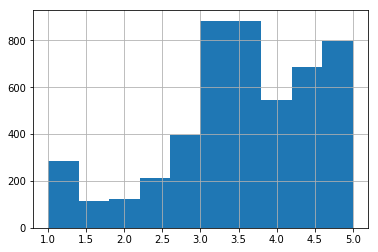

In [7]:
data_train,data_dev,data_test = data_loader.load_sick()
print('平均长度为%s'%str(sum([len(x.split() )for x in data_test['sent_2']])/len(data_test)))
data_train
#plt.hist([len(x.split() )for x in data_train['sent_2']])
data_test['sim'].hist()
#plt.scatter(list(range(len(data_test))),sorted(data_test['sim'].tolist()))
#data_test.describe()
#data_test['len'] = data_test.apply(lambda x:(len(x[0].split())+len(x[1].split()))/2,1)
#data_test.describe()

In [8]:
#组合不同的文本相似度计算pipeline，计算得到结果，pipeline 名称为多个阶段具体方法名称的连接：pipeline_key+preprocess_name+model_name+str(model_number)+postprocess_name+sim_method_class+sim_method_name
GensimModel.build_dictionary([nltk.word_tokenize(sentence) for sentence in data_train['sent_1'].tolist()+data_train['sent_2'].tolist()+data_dev['sent_1'].tolist()+data_dev['sent_2'].tolist()])
dataframe = pd.DataFrame(index = ['pearson','spearmanr'])
totalnum=0
track = True
for pipeline_key,pipeline_value in config['pipeline'].items():
    for preprocess_name in map(lambda x:x.strip(),pipeline_value['preprocess'].split(',')):
        if(preprocess_name=='None'):
            preprocess = lambda x:x
        elif(preprocess_name == 'move_stopword'):
            preprocess = lambda x:x
        elif(preprocess_name == 'tokenlize'):
            preprocess = lambda x:nltk.word_tokenize(x)
        else:
            raise NameError
        from scipy.sparse import coo_matrix
        for model_name in map(lambda x:x.strip(),pipeline_value['model'].keys()):
            model_numbers = map(lambda x: x.strip(), pipeline_value['model'][model_name].split(',')) if model_name != 'None' else [None]
            for model_number in model_numbers:
                if(model_name=='None'):
                    model = lambda x :x
                elif(model_name=='gensim_model'):
                    model = GensimModel(config['models'][model_name][model_number]['name'])
                elif(model_name=='transformer_model'):
                    transformer_model = AutoModel.from_pretrained(config['models'][model_name][model_number]['name'])#bert-base-uncased')
                    tokenizer = AutoTokenizer.from_pretrained(config['models'][model_name][model_number]['name'])
                    #model(**tokenizer('i want', return_tensors='pt'))
                    model = lambda x:transformer_model(**tokenizer(x,return_tensors='pt'))[0]
                elif(model_name == 'word2vec_model'):
                    model = Word2Vec(**config['models'][model_name][model_number])
                else:
                    raise NameError
                for postprocess_name in map(lambda x:x.strip(),pipeline_value['postprocess'].split(',')) :
                    if(postprocess_name == 'None'):
                        postprocess = lambda x:x
                    elif(postprocess_name=='Avg'):
                        postprocess = lambda x:np.mean(x.detach().numpy() if type(x)==torch.Tensor else x,-2)
                    elif(postprocess_name=='MaxPool'):
                        postprocess = lambda x:np.max(x.detach().numpy() if type(x)==torch.Tensor else x,-2)
                    elif(postprocess_name=='SelectOne'):
                        postprocess = lambda x:x.detach().numpy()[:,0]
                    else:
                      raise NameError
                    for sim_method_class in tqdm(map(lambda x: x.strip(), pipeline_value['simillarity'].keys())):
                        for sim_method_name in  tqdm(map(lambda x: x.strip(),config['simillarity'][sim_method_class].split(','))):
                           sim = getattr(td, sim_method_name)() if 'WMD' not in sim_method_name else getattr(td, sim_method_name)(model)
                           sim = sim.similarity if 'vector' not in sim_method_class else sim
                           res = [sim(postprocess(model(preprocess(sentencepair[0]))),postprocess(model(preprocess(sentencepair[1])))) for sentencepair in zip(data_test["sent_1"].tolist(),data_test["sent_2"].tolist())]
                           res = list(map(lambda x:-x,res)) if 'vector'  in sim_method_class else res
                           pearson_correlation = scipy.stats.pearsonr(res,data_test['sim'].tolist())[0]
                           spearmanr_correlation = scipy.stats.spearmanr(res,data_test['sim'].tolist())[0]
                           if(track):
                               with mlflow.start_run():
                                   log_param('dataset','sick')
                                   log_param('pipelinekey',pipeline_key)
                                   log_param('preprocess',preprocess_name)
                                   log_param('model_key',model_name)
                                   log_param('modelnumber',str(model_number))
                                   log_param('postprocess',postprocess_name)
                                   log_param('sim_method',sim_method_class)
                                   log_param('sim_method_name',sim_method_name)
                                   log_metric('pearson',pearson_correlation)
                                   log_metric('spearmanr',spearmanr_correlation)
                               dataframe [str(totalnum)+'_'+pipeline_key+preprocess_name+model_name+str(model_number)+postprocess_name+sim_method_class+sim_method_name] = [pearson_correlation,spearmanr_correlation]
                               totalnum+=1
plt.rcParams['font.size'] = 7
fig = dataframe.T.plot.bar()
plt.tight_layout()
plt.show()

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [02:00, 120.71s/it]
2it [04:57, 153.72s/it]
3it [04:59, 84.28s/it] d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]

4it [05:00, 51.49s/it]
5it [05:02, 33.73s/it]
6it [05:05, 23.22s/it]
7it [05:06, 16.03s/it]
8it [05:08, 38.52s/it]
1it [05:08, 308.12s/it]
0it [00:00, ?it/s]
1it [00:00,  1.54it/s]
2it [00:01,  1.45it/s]
3it [01:25, 39.01s/it]
4it [02:24, 46.56s/it]
5it [02:25, 30.21s/it]
6it [02:26, 20.38s/it]
7it [02:28, 14.48s/it]
8it [04:00, 39.16s/it]
9it [10:33, 149.58s/it]
10it [13:1

ConnectionError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/bert-base-uncased (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001D9EAE871D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

我们来看看实验结果，实验结果并不非常一致，我们发现在sick数据集上transformer的效果很好，结合各种后处理方法的效果变化不大比较稳定,word2vec的不同组合之间的差异较大,在所有变化中word2vec结合wmd距离的效果最好，
非学习方法中，基于压缩的BWT,ZLI方法表现突出。在sts数据集中,实验结果大不相同，word2vec的各种变化效果最好，特别是结合cosine，结合wmd距离的效果并不好;transformer的不同组合之间变化很大，在所有变化中transformer结合maxpool,cosine的效果最好;非学习方法中，ZLI,LZM的效果最好。
在两个数据上，对于transformer来说先用maxpool再结合相似度计算方法的效果要好于平均化和取cls字符向量;对于word2vec来说并没有在两个数据集上一直表现最好的组合方法。

tansformer和word2vec均需要结合其他方法进行实验，不同的结合方法效果差异很大，同类模型的变体之间的效果差异很大，没有哪一类模型效果绝对的好，各自有各自的长处。

非学习方法不许要调参，只是大部分非学习方法效果一般，基于压缩的[ZLI方法](https://en.wikipedia.org/wiki/Zlib)在两个数据集上都取得了很好的效果，而且不需要调参，它应当是一个值得考虑的baseline。
<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);"
    src="output/stsplot.png" width = "65%" alt=""/>
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">
      sts数据集
  	</div>
</center>
<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);"
    src="output/sick.png" width = "65%" alt=""/>
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">
      sick数据集
  	</div>
</center>

